# Grad-CAM

In [1]:
import torch
from torchvision import models, utils
import cv2
import sys
import numpy as np
import argparse
from torchvision import transforms
import skimage.transform

In [2]:
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers):
        self.model = model # vgg19
        self.target_layers = target_layers # 36
        self.feature_extractor = self.model.features # vgg19 features
    
    def save_gradient(self, grad):
    	self.gradients = grad
        
    def __call__(self, x): ## input image -> x
        for idx, module in self.model.features._modules.items(): # conv1, bn1, 하나씩 호출
            x = module(x) # 각 layer를 돌면서 forward
            if int(idx) == self.target_layers: # 36 backward hook
                x.register_hook(self.save_gradient)  ##set backward hoot
                target_activations = x ## 36번째 layer를 통과한 feature map 
                
        x = x
        x = x.view(x.size(0), -1)
        output = self.model.classifier(x)
        return target_activations, output
## target layer에 BACKWARD HOOK걸어주기 -> 나중에 BACKWARD 호출시 GRAD 추출가능
## target layer에 대한 activation (feature map)을 return
## prediction값 return 


In [4]:
class GradCam:
    def __init__(self, model, target_layer_names): ## model, target_layer
        self.model = model
        self.model.eval()
        self.extractor = ModelOutputs(self.model, target_layer_names)        
        
    def __call__(self, input, index): ## input: image, index: class
        
        features, output = self.extractor(input) 
        ## features: 36 -> feature map [1, c, h, w]
        ## output: [1, 1000]: prediction 
        
        ##define one hot vector that is 1 at the index
        one_hot = np.zeros((1, output.size()[-1])) # [1, 1000] zero np array
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad = True ## [1, 1000] 원하는 cls만 1인 one-hot vector
        one_hot = one_hot.cuda() * output ## [1, 1000] 모두 0으로 채워졌는데, index cls만 s_c
        one_hot = torch.sum(one_hot) # scalar value -> s_c
        
        ##backward through the model
        self.model.zero_grad() ## grad 를 없애줌
        one_hot.backward() # backward hook -> 
        
        ##get gradient to the corresponding layer
        grads_val = self.extractor.gradients.cpu().detach().numpy() ## gradient tensor를 구함
        ## grads_val: [1, c, h, w]
        grads_val = grads_val[0, :]
        
        ##get target feature map
        target = features # [1, c, h, w]
        target = target.cpu().detach().numpy()[0, :] # [c, h, w]
        
        ##perform channel wise GAP
        ## grads_val [c, h, w]
        weights = np.mean(grads_val, axis = (1,2)) # [c]
        
        ##reshape and get CAM
        cam = weights.reshape(-1, 1, 1) * target # [c, h, w]
        ## weights [c, 1, 1] target: [c, h, w]
        cam = cam.sum(axis = 0) # [h, w]
        ## relu
        cam = np.maximum(cam, 0)
        
        ## normalize
        cam = cam - np.min(cam)
        cam = cam / np.max(cam) # -np.min(cam)
        
        return cam, index

In [5]:
model = models.vgg19(pretrained=True).cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Visualize using Grad CAM
### You may change "target_layer_names", "target_index"

True


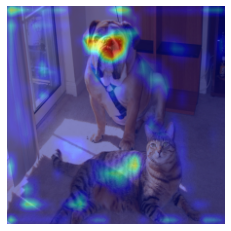

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow

grad_cam = GradCam(model, target_layer_names = 25)

image = Image.open("both.png").convert('RGB')

input_img = preprocess(image).unsqueeze(0) ## tensor batch
input_img = input_img.cuda() ## gpu
input_img.requires_grad = True 
print(input_img.requires_grad)

# tiger cat 282 / boxer 242
target_index = 242 ## cls

#get Grad CAM
mask, index = grad_cam(input_img, target_index)
# mask, index = grad_cam(input_img, None)

display_transform = transforms.Compose([transforms.Resize((224,224))])
#visualization
imshow(display_transform(image))
imshow(skimage.transform.resize(mask, (224, 224), mode='constant'), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()


True
(1, 224, 224)


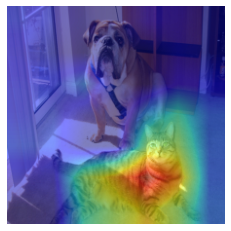

In [7]:
##use CAM from github
!pip install grad-cam
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


target_layers = [model.features[-1]]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda= True)

image = Image.open("both.png").convert("RGB")

input_img = preprocess(image).unsqueeze(0)
input_img = input_img.cuda()
input_img.requires_grad = True
print(input_img.requires_grad)

# tiger cat 282 / boxer 242
target_index = 282

#get Grad CAM
mask = cam(input_img, [ClassifierOutputTarget(target_index)])
# mask, index = grad_cam(input_img, None)

print(mask.shape)
#visualization
imshow(display_transform(image))
imshow(skimage.transform.resize(mask[0], input_img.shape[2:4], mode='constant'), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()
